# Football Player Detection Model

In [ ]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Clone TensorFlow Model Garden
!git clone --depth 1 https://github.com/tensorflow/models/

fatal: destination path 'models' already exists and is not an empty directory.


In [ ]:
# install the Tensorflow Object Detection API
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Preparing metadata (setup.py) ... done
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=21919980 sha256=535be9c6f0a2bf97b504718e0fc0f59b928dddba367f226058e129db9357d6f6
  Stored in directory: /tmp/pip-ephem-wheel-cache-c0wofbcs/wheels/7d/96/c1/072a751379735e8dfdada1def1c62a89afb3cc45654fd6fd28
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# import module for visualization. use the alias `viz_utils`
from object_detection.utils  import visualization_utils as viz_utils
from object_detection.utils import colab_utils

%matplotlib inline

In [ ]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Function to visualize detections.

    Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape for the boxes
    classes: The numpy array of shape for the classes
    scores: The numpy array of shape for the scores
    category_index: a dict of category dictionaries .
    figsize: size for the figure.
    image_name: The image file.
    """
    
    image_np_with_annotations = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)
    
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    
    else:
        plt.imshow(image_np_with_annotations)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    #     Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # return patches
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

In [ ]:
# Load train images and annotations
x_train = np.load("/content/drive/MyDrive/AI/Project/train/x_train_images.npy")
y_train = np.load("/content/drive/MyDrive/AI/Project/train/y_train_annotations.npy")
print(f"Shape of train images: {x_train.shape}")
print(f"Shape of train annotations: {y_train.shape}")

Shape of train images: (51, 224, 224, 3)
Shape of train annotations: (51, 4)


Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


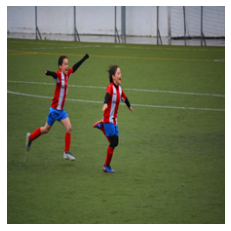

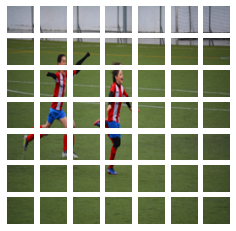

In [ ]:
patch_size = 32  # Size of the patches to be extracted from the input images
image_size = 224
plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

patches = Patches(patch_size)(tf.convert_to_tensor([x_train[0]]))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    inputs = layers.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.2)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    bounding_box = layers.Dense(4)(
        features
    )  # Final four neurons that output bounding box

    # return Keras model.
    return keras.Model(inputs=inputs, outputs=bounding_box)

In [ ]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile model.
    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

    checkpoint_filepath = "logs/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            checkpoint_callback,
            # keras.callbacks.EarlyStopping(monitor="val_loss", patience=20),
        ],
    )

    return history


input_shape = (image_size, image_size, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 2
num_epochs = 100
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers


history = []
num_patches = (image_size // patch_size) ** 2

vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

# Train model
history = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)

Epoch 1/100
23/23 [==============================] - 14s 314ms/step - loss: 34.7071 - val_loss: 1.4808
Epoch 2/100
23/23 [==============================] - 4s 176ms/step - loss: 108.8961 - val_loss: 2.1897
Epoch 3/100
23/23 [==============================] - 5s 202ms/step - loss: 27.1192 - val_loss: 0.1774
Epoch 4/100
23/23 [==============================] - 4s 176ms/step - loss: 13.5887 - val_loss: 0.2179
Epoch 5/100
23/23 [==============================] - 4s 178ms/step - loss: 14.0624 - val_loss: 0.2877
Epoch 6/100
23/23 [==============================] - 4s 178ms/step - loss: 4.0841 - val_loss: 0.2132
Epoch 7/100
23/23 [==============================] - 4s 173ms/step - loss: 3.0094 - val_loss: 0.3066
Epoch 8/100
23/23 [==============================] - 4s 177ms/step - loss: 1.6300 - val_loss: 0.3022
Epoch 9/100
23/23 [==============================] - 4s 173ms/step - loss: 0.9460 - val_loss: 0.2970
Epoch 10/100
23/23 [==============================] - 4s 177ms/step - loss: 1.3921 -

In [ ]:
# Load test images and annotations
x_test = np.load("/content/drive/MyDrive/AI/Project/test/x_test_images.npy", allow_pickle=True)
y_test = np.load("/content/drive/MyDrive/AI/Project/test/y_test_annotations.npy")
print(f"Shape of test images: {x_test.shape}")
print(f"Shape of test annotations: {y_test.shape}")

Shape of test images: (13,)
Shape of test annotations: (13, 4)


In [ ]:
# Saves the model in current path
vit_object_detector.save("/content/drive/MyDrive/AI/Project/model/vit_object_detector.h5", save_format="h5")

In [ ]:
import matplotlib.patches as patches

# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0]) * (
        box_predicted[3] - box_predicted[1]
    )
    box_truth_area = (box_truth[2] - box_truth[0]) * (
        box_truth[3] - box_truth[1]
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        (box_predicted_area + box_truth_area) - intersection_area
    )

In [ ]:
i, mean_iou = 0, 0
mean_iou_vals = []

# Compare results for 10 images in the test set
for input_image in x_test:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    # Display the image
    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))
    ax2.axis("on")
    
    input_image = cv2.resize(
        input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = vit_object_detector.predict(input_image)[0]

    (h, w) = (im).shape[0:2]
    if w > h:
      top_left_x, top_left_y = int(preds[0] * w * 3), int(preds[1] * h / 9)
      bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)
    else:
      top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)
      bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_y - top_left_y,
        bottom_right_x - top_left_x,
        
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )
    
    if w > h:
      top_left_x, top_left_y = int(y_test[i][0] * w * 3), int(y_test[i][1] * h / 9) 
      bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)
    else:
      top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h) 
      bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)
    
    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    mean_iou_vals.append(mean_iou)
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_y - top_left_y,
        bottom_right_x - top_left_x,        
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test)))

plt.show()

Output hidden; open in https://colab.research.google.com to view.

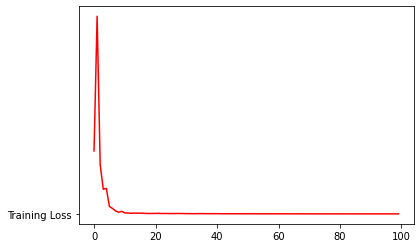

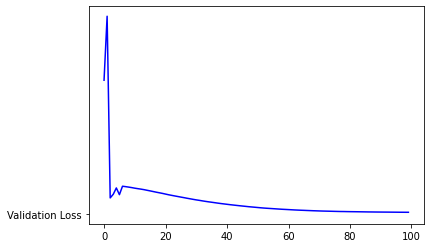

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.show()

plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [ ]:
# configure plot settings via rcParams
# plt.rcParams['axes.grid'] = False
# plt.rcParams['xtick.labelsize'] = False
# plt.rcParams['ytick.labelsize'] = False
# plt.rcParams['xtick.top'] = False
# plt.rcParams['xtick.bottom'] = False
# plt.rcParams['ytick.left'] = False
# plt.rcParams['ytick.right'] = False